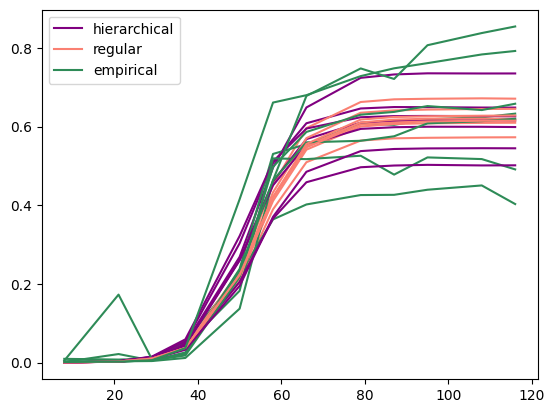

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import pickle
import sbi.utils as utils
import torch
from sbi.inference import MCMCPosterior
from scipy.special import logsumexp
from seaborn import histplot
from time import time
import sys  
sys.path.insert(1, '../')
from collective_posterior import CollectivePosterior
from simulators import wrapper, wrapper_hierarchical, WF
generation = np.array(pd.read_csv('empirical_data/Chuong_116_gens.txt').columns.astype('int'))

th = torch.tensor([-0.74,-4.84,-4.32], dtype=torch.float32)
X = wrapper(WF, parameters=th, reps=7) # LTRΔ MAP in paper
X_emp = torch.from_numpy(np.array(pd.read_csv('empirical_data/ltr.csv', index_col=0)))
X_h = wrapper_hierarchical(WF, parameters=th, reps=7)

for i in range(len(X)):
    plt.plot(generation,X_h[i], color='purple', label='hierarchical' if i==0 else '')
    plt.plot(generation,X[i], color='salmon', label='regular' if i==0 else '')
    plt.plot(generation,X_emp[i], color='seagreen', label='empirical' if i==0 else '')
plt.legend()

In [2]:
prior_min = np.log10(np.array([1e-2,1e-7,1e-8]))
prior_max = np.log10(np.array([1,1e-2,1e-2]))
prior = utils.BoxUniform(low=torch.tensor(prior_min), 
                         high=torch.tensor(prior_max))
posterior_chuong = pickle.load(open('posteriors/posterior_WF_100000_20.pkl', 'rb'))
epsilon = -150


Xs = torch.tensor(X_h)
op = CollectivePosterior(prior, posterior_chuong, Xs, 1, epsilon)

print(op.get_log_C())
est = op.sample(100).mean(0)
est

/tmp/ipykernel_1387207/954377585.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Xs = torch.tensor(X_h)


tensor(36.6842)


/home/jupyter-nadavbennun/Nadav/Posterior/collective_posterior/WF/../collective_posterior.py:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta = torch.tensor(theta, dtype=torch.float32)
Sampling: 100%|██████████| 100/100 [00:00<00:00, 723.98it/s]


tensor([-0.7229, -4.8527, -4.3188])

/home/jupyter-nadavbennun/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/jupyter-nadavbennun/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/jupyter-nadavbennun/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/jupyter-nadavbennun/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be

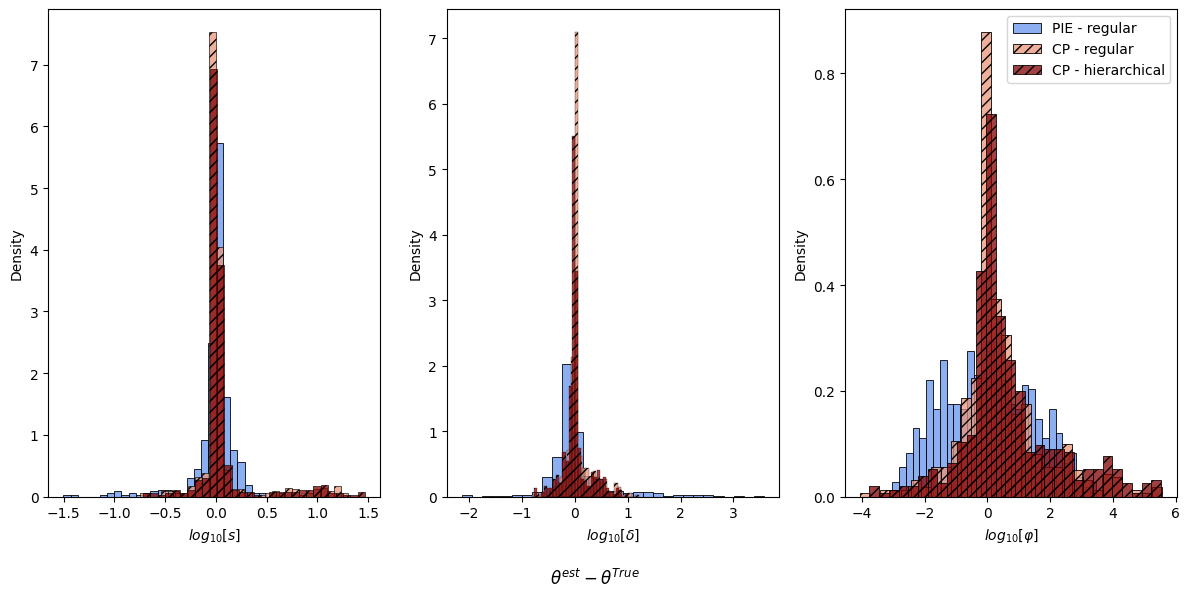

In [3]:
def plot_accuracy(acc_path, ax, color, label, hatch):
    res = pd.read_csv(acc_path, index_col=0, dtype='float')
    res = torch.from_numpy(np.array(res))
    for i in range(len(ax)):
        histplot(res[:,i],ax=ax[i], stat='density', color=color, bins=30, label=label, hatch=hatch)
    return

n_params=3
fig, ax = plt.subplots(1,n_params, figsize=(12,6), tight_layout=True, sharex=False)
ax[0].set_xlabel('$log_{10}[s]$')
ax[1].set_xlabel('$log_{10}[δ]$')
ax[2].set_xlabel('$log_{10}[φ]$')
fig.supxlabel('$θ^{est} - θ^{True}$')

iid_acc = 'tests/accus_WF_iid.csv'
plot_accuracy(iid_acc, ax, color='cornflowerblue', label='PIE - regular', hatch='')

cp_acc = 'tests/accus_WF.csv'
plot_accuracy(cp_acc, ax, color='darksalmon', label='CP - regular', hatch='///')

cp_acc_h = 'tests/accus_WF_h.csv'
plot_accuracy(cp_acc_h, ax, color='maroon', label='CP - hierarchical', hatch='///')
plt.legend()